# Fake and real news

**Problem**

One of the biggest worldwide challenges we are facing these days is misinformation. Incorrect information can be harmless in some contexts, but can be devastating in others. For example having an influence on the USA presidential election. So, to attempt to solve this problem we will be using a [Kaggle fake and real news dataset](https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset) for fake news classification. More specifically, this is an NLP problem, we will use article headlines and body text and will try to guess whether a particular article is fake or not.

Dataset details:
- Columns - article title, text, subject, date and label column
- From 2015-03-31 to 2018-02-19;
- Dataset size - 44679;
- Train size - 31275,  percentage - 70.0%;
- Validation size - 8936,  percentage - 20.0%;
- Test size - 4468,  percentage - 10.0%;

## Data preparation

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch.utils.data import Dataset, DataLoader

import torchmetrics as tm

from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer

import pytorch_lightning as pl

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, \
ConfusionMatrixDisplay, classification_report, accuracy_score
from sklearn.feature_selection import RFE

from scipy.sparse import hstack

from collections import defaultdict
import time

import shap

In [3]:
path_to_ds = '/kaggle/input/fake-and-real-news-dataset/'

true_df = pd.read_csv(path_to_ds+'True.csv')
true_df['real_news'] = 1
fake_df = pd.read_csv(path_to_ds+'Fake.csv')
fake_df['real_news'] = 0

full_df = pd.concat([true_df, fake_df]).reset_index(drop=True)

full_df.info()
full_df.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   title      44898 non-null  object
 1   text       44898 non-null  object
 2   subject    44898 non-null  object
 3   date       44898 non-null  object
 4   real_news  44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.7+ MB


,title,text,subject,date,real_news
24609,Kellyanne Conway Shamelessly Begs For Money A...,If you voted for Trump hoping for financial pr...,News,"January 2, 2017",0
22596,Former GOP Congressman TRASHES Paul Ryan: If ...,Now that fired FBI Director James Comey has of...,News,"June 11, 2017",0
25040,Trump Campaign Staffer Gets Convicted Of Elec...,This proves the need for a recount in Michigan...,News,"November 30, 2016",0
44030,‘America Is Under Israeli Occupation’ by Dahli...,21st Century Wire says The following video pre...,US_News,"March 25, 2016",0
42059,YIKES! 30 Years Of HILLARY’S LIES Have Driven ...,This is not a fluke. After years of towing the...,left-news,"May 2, 2016",0


In [4]:
mask = full_df['date'].str.contains(', 20') \
| full_df['date'].str.contains('Feb-18')

full_df.drop(index=full_df[~mask].index, inplace=True)

full_df['date'] = pd.to_datetime(full_df[mask]['date'])

Boolean Series key will be reindexed to match DataFrame index.


In [26]:
full_df.isna().sum()

title        0
text         0
subject      0
date         0
real_news    0
dtype: int64

In [27]:
full_df.duplicated().sum()

209

In [5]:
full_df.drop_duplicates(inplace=True)

In [6]:
train_perc = 0.7
valid_perc = 0.2

train_df, valid_df, test_df = np.split(
    full_df.sample(frac=1, random_state=0), 
    [
        int(train_perc*len(full_df)), 
        int((train_perc+valid_perc)*len(full_df))
    ]
)

train_val_df = pd.concat([train_df, valid_df])

In [7]:
print(f'Dataset size - {full_df.shape[0]}')
print(f'Train size - {train_df.shape[0]}, ',
      f'percentage - {round(100*train_df.shape[0]/full_df.shape[0], 2)}%')
print(f'Validation size - {valid_df.shape[0]}, ',
      f'percentage - {round(100*valid_df.shape[0]/full_df.shape[0], 2)}%')
print(f'Test size - {test_df.shape[0]}, ',
      f'percentage - {round(100*test_df.shape[0]/full_df.shape[0], 2)}%')

Dataset size - 44679
Train size - 31275,  percentage - 70.0%
Validation size - 8936,  percentage - 20.0%
Test size - 4468,  percentage - 10.0%


## EDA

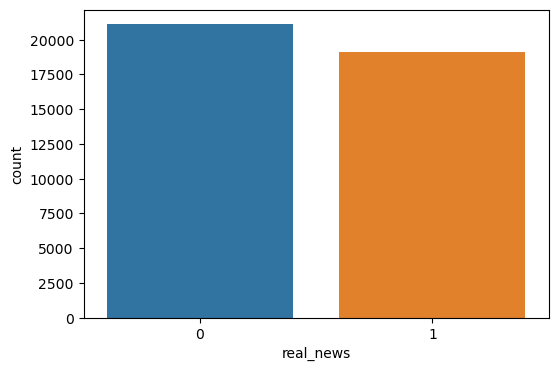

In [48]:
plt.figure(figsize=(6,4))
sns.countplot(x=train_val_df['real_news'])
plt.show()

Number of fake and real news is all almost the same so this dataset is rather balanced in terms of the classes.

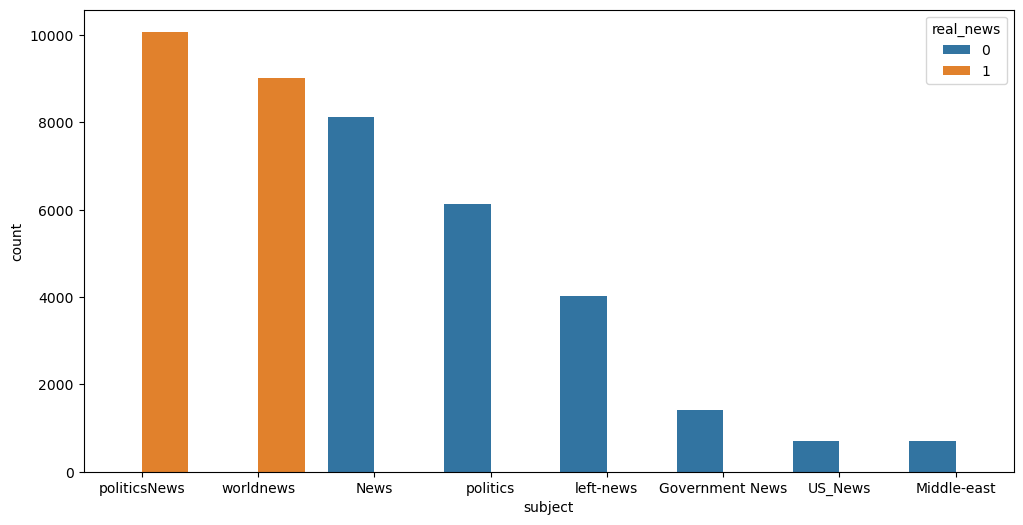

In [49]:
plt.figure(figsize=(12,6))
sns.countplot(x=train_val_df['subject'], 
              order=train_val_df['subject'].value_counts().index,
              hue=train_val_df['real_news'])
plt.show()

Seems that subject categories were named differently in fake and real csv files, so it is hard to know which categories to merge together. In this case this feature becomes useless.

In [8]:
train_val_df['title_word_count'] = train_val_df['title'].str.strip().str.len()
train_val_df['text_word_count'] = train_val_df['text'].str.strip().str.len()

In [51]:
train_val_df.describe()

,real_news,title_word_count,text_word_count
count,40211.000000,40211.000000,40211.000000
mean,0.475019,79.996518,2462.901022
std,0.499382,25.402939,2175.267402
min,0.000000,15.000000,0.000000
25%,0.000000,63.000000,1232.500000
50%,0.000000,73.000000,2181.000000
75%,1.000000,91.000000,3093.500000
max,1.000000,279.000000,51793.000000


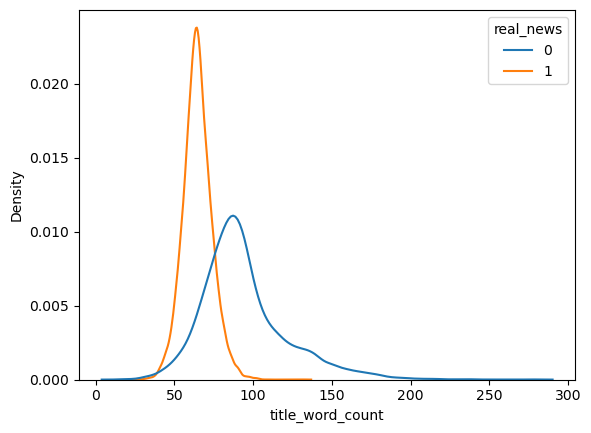

In [52]:
sns.kdeplot(x=train_val_df['title_word_count'], hue=train_val_df['real_news'])
plt.show()

We can definately see that there is a difference in title word count distributions for fake and real news. We can use this to create a rule with which we can distinguish the two classes and see what accuracy we can get.

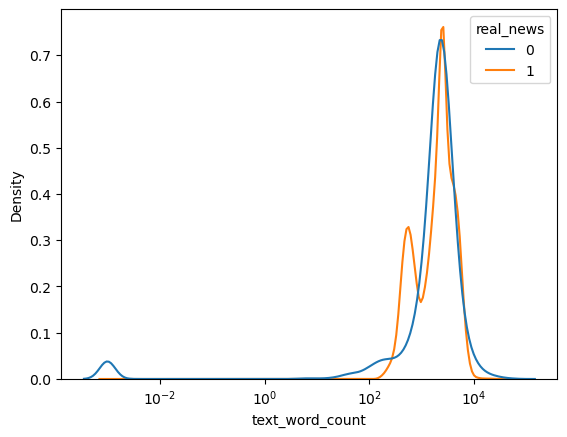

In [53]:
sns.kdeplot(
    x=train_val_df['text_word_count']+0.001, 
    hue=train_val_df['real_news'], 
    log_scale=True
)
plt.show()

There is some difference in terms of text word count, but not as much as with title word count.

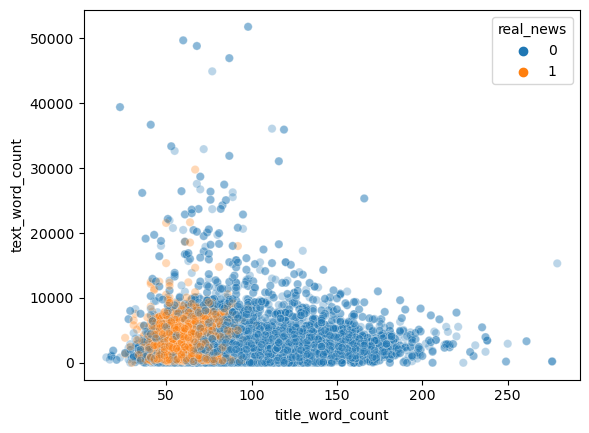

In [54]:
sns.scatterplot(
    x=train_val_df['title_word_count'], 
    y=train_val_df['text_word_count'], 
    hue=train_val_df['real_news'], 
    alpha=0.3
)
plt.show()

We can see that there is a cluster of real news in the smaller title word count range, but not too much difference in terms of text word count axis.

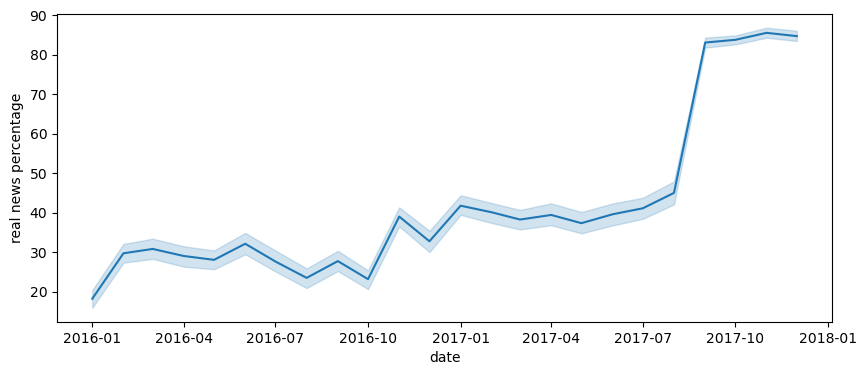

In [56]:
plt.figure(figsize=(10,4))

date_series = train_val_df[
    (train_val_df['date'].dt.year>2015) & (train_val_df['date'].dt.year<2018)
]['date'].dt.to_period('m').dt.to_timestamp()

ax = sns.lineplot(x=date_series, 
             y=train_val_df['real_news']*100)
ax.set_ylabel('real news percentage')
plt.show()

We can see that going from 2016 to 2017 the percentage of real news starts to increase in the dataset. This might be because of the USA presidential election.

## Rule based baseline

We will now create a baseline upon which we can improve using ML models with increasing complexity.

In [76]:
def decision_fcn(word_count: int, threshold: int=75) -> int:
    if word_count > threshold:
        return 0
    else:
        return 1

In [13]:
pred = train_val_df['title_word_count'].map(decision_fcn)

accuracy_score(train_val_df['real_news'], pred)

0.8273855412698018

In [9]:
train_df['title_word_count'] = train_df['title'].str.strip().str.len()
train_df['text_word_count'] = train_df['text'].str.strip().str.len()
valid_df['title_word_count'] = valid_df['title'].str.strip().str.len()
valid_df['text_word_count'] = valid_df['text'].str.strip().str.len()

In [15]:
clf = LogisticRegression()

clf.fit(train_df[['title_word_count','text_word_count']],
        train_df['real_news'])

accuracy_score(valid_df['real_news'], 
               clf.predict(valid_df[['title_word_count','text_word_count']]))

0.8238585496866607

We can see that just by using a simple title word count decision function, where if the title word count is above 75 the news are real, we were able to achieve 83% accuracy. Also, logistic regression got almost the same accuracy.

## Training ML models with tfidf features

In order to use machine learning models we need to extract certain features from the text, because we can't pass text as input to these models. To achieve that we will use TFIDF vectorizer, which will create chosen number of features from text with highest TFIDF scores. TFIDF is calculated by multiplying TF (frequency of a word appearing in a text document) and IDF (log of frequency of a word appearing in the whole corpus of text documents). We will try out logistic regression, decision tree and random forest algorithms.

In [32]:
tfidf_title_vec = TfidfVectorizer(ngram_range=(1, 1), max_features=10,
                                  stop_words="english")

title_features_train = tfidf_title_vec.fit_transform(train_df['title'])
title_features_valid = tfidf_title_vec.transform(valid_df['title'])


tfidf_text_vec = TfidfVectorizer(ngram_range=(1, 1), max_features=10,
                                 stop_words="english")

text_features_train = tfidf_text_vec.fit_transform(train_df['text'])
text_features_valid = tfidf_text_vec.transform(valid_df['text'])


title_features = [s+'_title' for s in tfidf_title_vec.vocabulary_.keys()]
text_features = [s+'_text' for s in tfidf_text_vec.vocabulary_.keys()]


train_features_df = pd.DataFrame()

train_features_df[title_features] = title_features_train.toarray()\
[:,list(tfidf_title_vec.vocabulary_.values())]

train_features_df[text_features] = text_features_train.toarray()\
[:,list(tfidf_text_vec.vocabulary_.values())]


valid_features_df = pd.DataFrame()

valid_features_df[title_features] = title_features_valid.toarray()\
[:,list(tfidf_title_vec.vocabulary_.values())]

valid_features_df[text_features] = text_features_valid.toarray()\
[:,list(tfidf_text_vec.vocabulary_.values())]

              precision    recall  f1-score   support

        fake    0.97985   0.98854   0.98418      4625
        real    0.98759   0.97820   0.98287      4311

    accuracy                        0.98355      8936
   macro avg    0.98372   0.98337   0.98352      8936
weighted avg    0.98359   0.98355   0.98355      8936



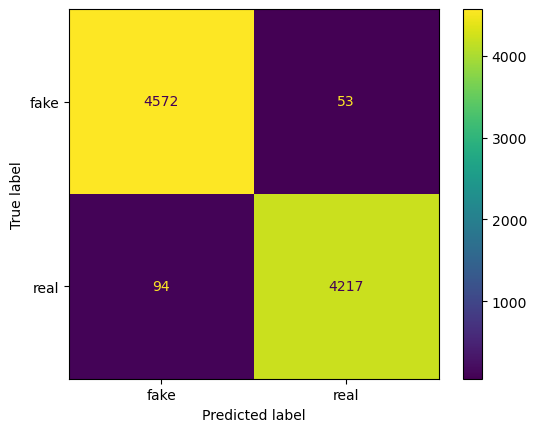

In [63]:
log_clf = LogisticRegression(random_state=0)

log_clf.fit(train_features_df, train_df['real_news'])

pred = log_clf.predict(valid_features_df)

print(classification_report(valid_df['real_news'], pred, 
                            target_names=['fake', 'real'],
                            digits=5))
ConfusionMatrixDisplay(confusion_matrix(valid_df['real_news'], pred),
                       display_labels=['fake', 'real']).plot()
plt.show()

              precision    recall  f1-score   support

        fake    0.99115   0.99265   0.99190      4625
        real    0.99210   0.99049   0.99129      4311

    accuracy                        0.99161      8936
   macro avg    0.99162   0.99157   0.99160      8936
weighted avg    0.99161   0.99161   0.99161      8936



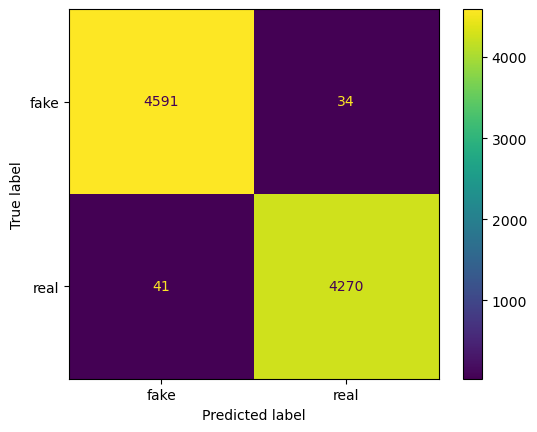

In [64]:
dt_clf = DecisionTreeClassifier(random_state=0)

dt_clf.fit(train_features_df, train_df['real_news'])

pred = dt_clf.predict(valid_features_df)

print(classification_report(valid_df['real_news'], pred, 
                            target_names=['fake', 'real'],
                            digits=5))
ConfusionMatrixDisplay(confusion_matrix(valid_df['real_news'], pred),
                       display_labels=['fake', 'real']).plot()
plt.show()

              precision    recall  f1-score   support

        fake    0.99696   0.99286   0.99491      4625
        real    0.99238   0.99675   0.99456      4311

    accuracy                        0.99474      8936
   macro avg    0.99467   0.99481   0.99473      8936
weighted avg    0.99475   0.99474   0.99474      8936



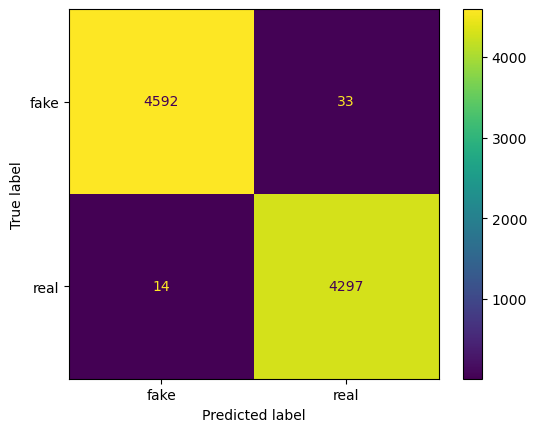

In [65]:
rf_clf = RandomForestClassifier(random_state=0)

rf_clf.fit(train_features_df, train_df['real_news'])

pred = rf_clf.predict(valid_features_df)

print(classification_report(valid_df['real_news'], pred, 
                            target_names=['fake', 'real'],
                            digits=5))
ConfusionMatrixDisplay(confusion_matrix(valid_df['real_news'], pred),
                       display_labels=['fake', 'real']).plot()
plt.show()

We got 98.4%, 99.2%, 99.5% from logistic regression, decision tree and random forest respectively. These are nearly perfect results even from logistic regression, but let's see feature importances for these models.

In [46]:
log_clf = LogisticRegression(random_state=0)
selector = RFE(log_clf, n_features_to_select=1)
selector = selector.fit(train_features_df, train_df['real_news'])
feature_ranks = pd.Series(selector.ranking_, index=train_features_df.columns)
feature_ranks.sort_values()

reuters_text       1
video_title        2
hillary_title      3
watch_title        4
said_text          5
donald_text        6
trump_text         7
clinton_text       8
state_text         9
obama_text        10
new_text          11
president_text    12
clinton_title     13
says_title        14
house_title       15
white_title       16
new_title         17
trump_title       18
obama_title       19
people_text       20
dtype: int64

In [47]:
dt_clf = DecisionTreeClassifier(random_state=0)
selector = RFE(dt_clf, n_features_to_select=1)
selector = selector.fit(train_features_df, train_df['real_news'])
feature_ranks = pd.Series(selector.ranking_, index=train_features_df.columns)
feature_ranks.sort_values()

reuters_text       1
said_text          2
state_text         3
obama_text         4
trump_text         5
donald_text        6
people_text        7
president_text     8
hillary_title      9
new_text          10
video_title       11
clinton_text      12
says_title        13
new_title         14
white_title       15
trump_title       16
house_title       17
clinton_title     18
obama_title       19
watch_title       20
dtype: int64

In [48]:
rf_clf = RandomForestClassifier(random_state=0)
selector = RFE(rf_clf, n_features_to_select=1)
selector = selector.fit(train_features_df, train_df['real_news'])
feature_ranks = pd.Series(selector.ranking_, index=train_features_df.columns)
feature_ranks.sort_values()

reuters_text       1
said_text          2
video_title        3
trump_text         4
says_title         5
people_text        6
hillary_title      7
president_text     8
watch_title        9
donald_text       10
state_text        11
obama_text        12
clinton_text      13
new_text          14
obama_title       15
trump_title       16
house_title       17
clinton_title     18
white_title       19
new_title         20
dtype: int64

We can see that the 'reuters' TFIDF feature is the most important. Let's train the models only using this feature.

              precision    recall  f1-score   support

        fake    0.95448   0.98832   0.97111      4625
        real    0.98698   0.94943   0.96784      4311

    accuracy                        0.96956      8936
   macro avg    0.97073   0.96888   0.96947      8936
weighted avg    0.97016   0.96956   0.96953      8936



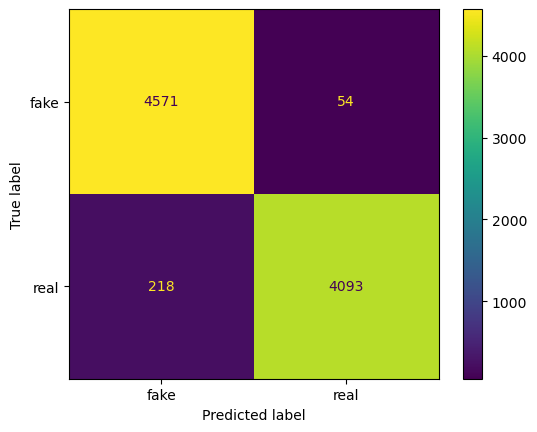

In [66]:
log_clf = LogisticRegression(random_state=0)

log_clf.fit(train_features_df[['reuters_text']], train_df['real_news'])

pred = log_clf.predict(valid_features_df[['reuters_text']])

print(classification_report(valid_df['real_news'], pred, 
                            target_names=['fake', 'real'],
                            digits=5))
ConfusionMatrixDisplay(confusion_matrix(valid_df['real_news'], pred),
                       display_labels=['fake', 'real']).plot()
plt.show()

              precision    recall  f1-score   support

        fake    0.99264   0.99135   0.99199      4625
        real    0.99073   0.99211   0.99142      4311

    accuracy                        0.99172      8936
   macro avg    0.99169   0.99173   0.99171      8936
weighted avg    0.99172   0.99172   0.99172      8936



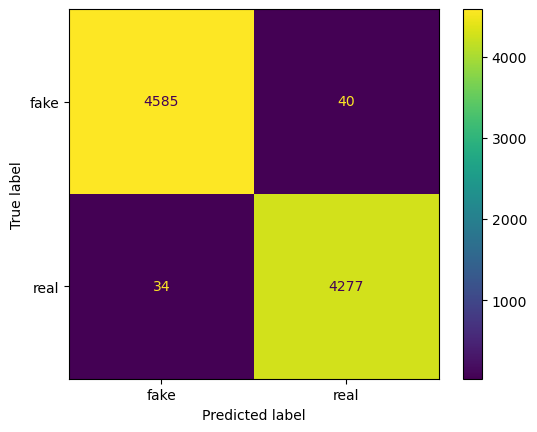

In [67]:
dt_clf = DecisionTreeClassifier(random_state=0)

dt_clf.fit(train_features_df[['reuters_text']], train_df['real_news'])

pred = dt_clf.predict(valid_features_df[['reuters_text']])

print(classification_report(valid_df['real_news'], pred, 
                            target_names=['fake', 'real'],
                            digits=5))
ConfusionMatrixDisplay(confusion_matrix(valid_df['real_news'], pred),
                       display_labels=['fake', 'real']).plot()
plt.show()

              precision    recall  f1-score   support

        fake    0.99307   0.99092   0.99199      4625
        real    0.99028   0.99258   0.99143      4311

    accuracy                        0.99172      8936
   macro avg    0.99167   0.99175   0.99171      8936
weighted avg    0.99172   0.99172   0.99172      8936



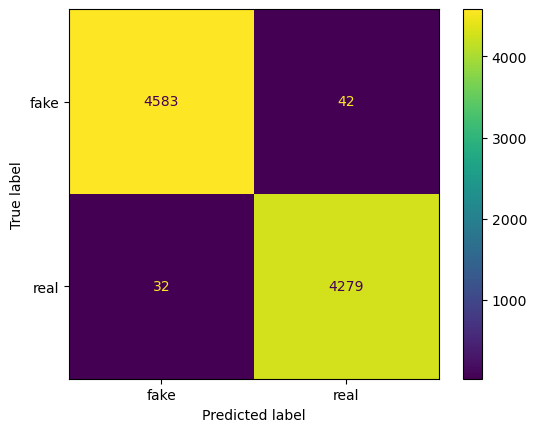

In [68]:
rf_clf = RandomForestClassifier(random_state=0)

rf_clf.fit(train_features_df[['reuters_text']], train_df['real_news'])

pred = rf_clf.predict(valid_features_df[['reuters_text']])

print(classification_report(valid_df['real_news'], pred, 
                            target_names=['fake', 'real'],
                            digits=5))
ConfusionMatrixDisplay(confusion_matrix(valid_df['real_news'], pred),
                       display_labels=['fake', 'real']).plot()
plt.show()

As we can see only using this feature the accuracy doesn't decrease a lot and for decision tree model it doesn't decrease at all. Let's now train the models without using this feature.

              precision    recall  f1-score   support

        fake    0.86937   0.84757   0.85833      4625
        real    0.84075   0.86337   0.85191      4311

    accuracy                        0.85519      8936
   macro avg    0.85506   0.85547   0.85512      8936
weighted avg    0.85556   0.85519   0.85523      8936



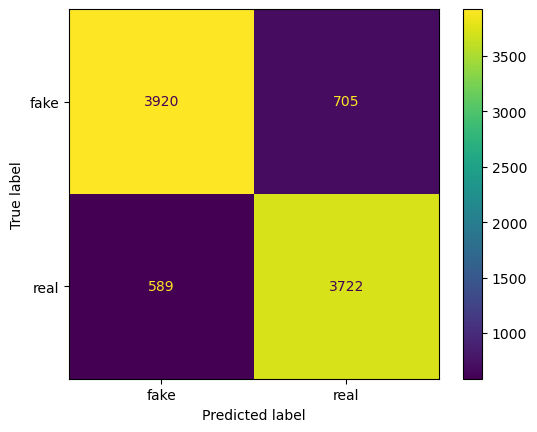

In [69]:
log_clf = LogisticRegression(random_state=0)

log_clf.fit(train_features_df.drop(columns=['reuters_text']), train_df['real_news'])

pred = log_clf.predict(valid_features_df.drop(columns=['reuters_text']))

print(classification_report(valid_df['real_news'], pred, 
                            target_names=['fake', 'real'],
                            digits=5))
ConfusionMatrixDisplay(confusion_matrix(valid_df['real_news'], pred),
                       display_labels=['fake', 'real']).plot()
plt.show()

              precision    recall  f1-score   support

        fake    0.90459   0.92454   0.91446      4625
        real    0.91708   0.89538   0.90610      4311

    accuracy                        0.91047      8936
   macro avg    0.91084   0.90996   0.91028      8936
weighted avg    0.91062   0.91047   0.91043      8936



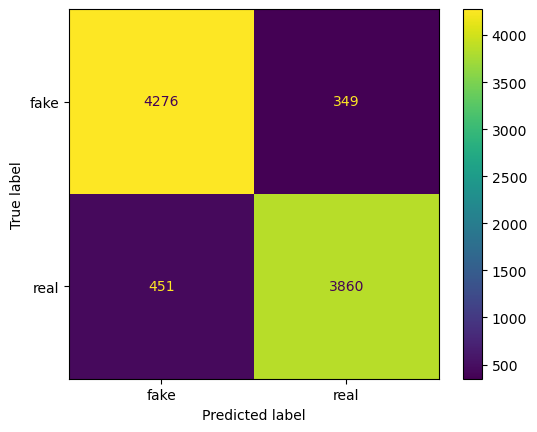

In [70]:
dt_clf = DecisionTreeClassifier(random_state=0)

dt_clf.fit(train_features_df.drop(columns=['reuters_text']), train_df['real_news'])

pred = dt_clf.predict(valid_features_df.drop(columns=['reuters_text']))

print(classification_report(valid_df['real_news'], pred, 
                            target_names=['fake', 'real'],
                            digits=5))
ConfusionMatrixDisplay(confusion_matrix(valid_df['real_news'], pred),
                       display_labels=['fake', 'real']).plot()
plt.show()

              precision    recall  f1-score   support

        fake    0.93227   0.94638   0.93927      4625
        real    0.94152   0.92624   0.93382      4311

    accuracy                        0.93666      8936
   macro avg    0.93690   0.93631   0.93654      8936
weighted avg    0.93673   0.93666   0.93664      8936



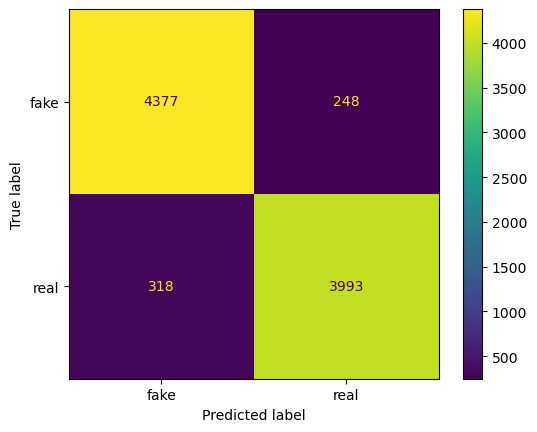

In [71]:
rf_clf = RandomForestClassifier(random_state=0)

rf_clf.fit(train_features_df.drop(columns=['reuters_text']), train_df['real_news'])

pred = rf_clf.predict(valid_features_df.drop(columns=['reuters_text']))

print(classification_report(valid_df['real_news'], pred, 
                            target_names=['fake', 'real'],
                            digits=5))
ConfusionMatrixDisplay(confusion_matrix(valid_df['real_news'], pred),
                       display_labels=['fake', 'real']).plot()
plt.show()

Not using the 'reuters' TFIDF feature reduces the accuracy by quite a bit for some models. For example logistic regression where the accurcy is down to 86%, which is close to what we would get just by using the rule based method.

## Training DistilBERT

In [15]:
from model import *
from data import *
from utils import *

In [ ]:
model = FakeTrueNewsClfModel(
    train_df=train_df,
    valid_df=valid_df,
    test_df=test_df,
    max_sequence_length=64
)

trainer = pl.Trainer(max_epochs=1)

trainer.fit(model)

Predicting: 0it [00:00, ?it/s]

              precision    recall  f1-score   support

        fake    0.99655   0.99870   0.99762      4625
        real    0.99860   0.99629   0.99745      4311

    accuracy                        0.99754      8936
   macro avg    0.99758   0.99750   0.99753      8936
weighted avg    0.99754   0.99754   0.99754      8936



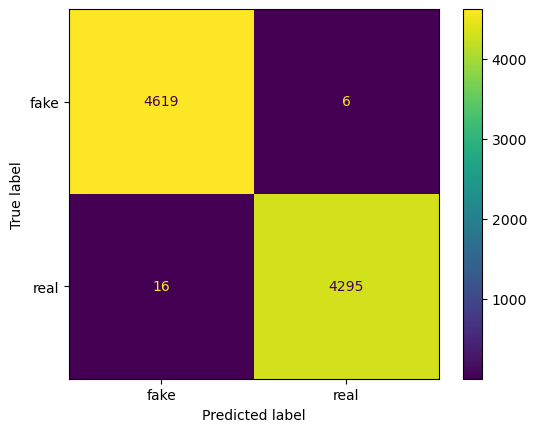

In [74]:
pred = trainer.predict(model, dataloaders=model.val_dataloader())
pred = process_output(pred)

print(classification_report(valid_df['real_news'], pred, 
                            target_names=['fake', 'real'],
                            digits=5))
ConfusionMatrixDisplay(confusion_matrix(valid_df['real_news'], pred),
                       display_labels=['fake', 'real']).plot()
plt.show()

So using DistilBERT gave us better results, but by a small amount and there would also be considerations whether or not it is worth using such a complex model compared to logistic regression.

## Evaluation

In [81]:
test_scores = defaultdict(list)

test_df['title_word_count'] = test_df['title'].str.strip().str.len()

test_scores['model'].append('title_wc_threshold_funcion')

t1 = time.time()
pred = test_df['title_word_count'].map(decision_fcn)
pred_time = (time.time() - t1)*1000
test_scores['test set prediction time (ms)'].append(pred_time)

test_scores['accuracy'].append(
    accuracy_score(
        test_df['real_news'], 
        pred
    )
)

In [75]:
text_features_test = tfidf_text_vec.transform(test_df['text'])

test_features_df = pd.DataFrame()

test_features_df[text_features] = text_features_test.toarray()\
[:,list(tfidf_text_vec.vocabulary_.values())]

In [82]:
log_clf.fit(train_features_df[['reuters_text']], train_df['real_news'])
dt_clf.fit(train_features_df[['reuters_text']], train_df['real_news'])
rf_clf.fit(train_features_df[['reuters_text']], train_df['real_news'])

test_scores['model'].append('logistic_regression')

t1 = time.time()
pred = log_clf.predict(test_features_df[['reuters_text']])
pred_time = (time.time() - t1)*1000
test_scores['test set prediction time (ms)'].append(pred_time)

test_scores['accuracy'].append(
    accuracy_score(test_df['real_news'], pred)
)


test_scores['model'].append('decision_tree')

t1 = time.time()
pred = dt_clf.predict(test_features_df[['reuters_text']])
pred_time = (time.time() - t1)*1000
test_scores['test set prediction time (ms)'].append(pred_time)

test_scores['accuracy'].append(
    accuracy_score(test_df['real_news'], pred)
)


test_scores['model'].append('random_forest')

t1 = time.time()
pred = rf_clf.predict(test_features_df[['reuters_text']])
pred_time = (time.time() - t1)*1000
test_scores['test set prediction time (ms)'].append(pred_time)

test_scores['accuracy'].append(
    accuracy_score(test_df['real_news'], pred)
)

In [83]:
t1 = time.time()
pred = trainer.predict(model, dataloaders=model.test_dataloader())
pred_time = (time.time() - t1)*1000
test_scores['test set prediction time (ms)'].append(pred_time)
pred = process_output(pred)

test_scores['model'].append('bert')
test_scores['accuracy'].append(accuracy_score(test_df['real_news'], pred))

Predicting: 0it [00:00, ?it/s]

In [84]:
pd.DataFrame(test_scores)

,model,test set prediction time (ms),accuracy
0,title_wc_threshold_funcion,3.368855,0.826321
1,logistic_regression,2.847672,0.969114
2,decision_tree,2.798319,0.993062
3,random_forest,67.919970,0.993286
4,bert,11175.070286,0.997314


We can see that the results are slightly worse on the test set than on the validation set which is great. Also, we can see that DistilBERT inference time is orders of magnitude worse than other ML models, because of its complexity.

## Error analysis

Let's investigate why some samples in the test set had high prediction error. We will compare the means of 'reuters' TFIDF feature of top 30 error samples with random samples from real and fake news.

In [97]:
pred = dt_clf.predict_proba(test_features_df[['reuters_text']])
test_df['prob'] = pred[:,1]
test_df['error'] = (test_df['real_news'] - test_df['prob']).abs()

test_df['reuters'] = test_features_df['reuters_text'].values

top30_error = test_df.sort_values(by='error', 
                                  ascending=False).iloc[:30]

In [106]:
fake_error = top30_error[top30_error['real_news']==0][['reuters']].mean()
fake_error = pd.DataFrame(data=fake_error, columns=['mean'])
fake_error['std'] = top30_error[top30_error['real_news']==0][['reuters']].std()
fake_error['group'] = 'top30error_fake_news_samples'
fake_error.reset_index(names=['feature'], inplace=True)

fake_means = test_df[test_df['real_news']==0][['reuters']].sample(100).mean()
fake_means = pd.DataFrame(data=fake_means, columns=['mean'])
fake_means['std'] = test_df[test_df['real_news']==0][['reuters']].sample(100).std()
fake_means['group'] = 'random_fake_news_samples'
fake_means.reset_index(names=['feature'], inplace=True)

df = pd.concat(
    [fake_error, fake_means]
).reset_index(drop=True)

df

,feature,mean,std,group
0,reuters,0.196678,0.149577,top30error_fake_news_samples
1,reuters,0.009442,0.018475,random_fake_news_samples


In [107]:
real_error = top30_error[top30_error['real_news']==1][['reuters']].mean()
real_error = pd.DataFrame(data=real_error, columns=['mean'])
real_error['std'] = top30_error[top30_error['real_news']==1][['reuters']].std()
real_error['group'] = 'top30error_real_news_samples'
real_error.reset_index(names=['feature'], inplace=True)

real_means = test_df[test_df['real_news']==1][['reuters']].sample(100).mean()
real_means = pd.DataFrame(data=real_means, columns=['mean'])
real_means['std'] = test_df[test_df['real_news']==1][['reuters']].sample(100).std()
real_means['group'] = 'random_real_news_samples'
real_means.reset_index(names=['feature'], inplace=True)

df = pd.concat(
    [real_error, real_means]
).reset_index(drop=True)

df

,feature,mean,std,group
0,reuters,0.157562,0.173692,top30error_real_news_samples
1,reuters,0.316815,0.208781,random_real_news_samples


We can see that some fake news samples had high 'reuters' TFIDF feature value which resulted in the model predicting real news and vice versa with some real news samples.

## Model explainability

We will now observe what influence the 'reuters' TFIDF feature has on the output by using SHAP plots. And also we will see a few samples on how the DistilBERT model does prediction.

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


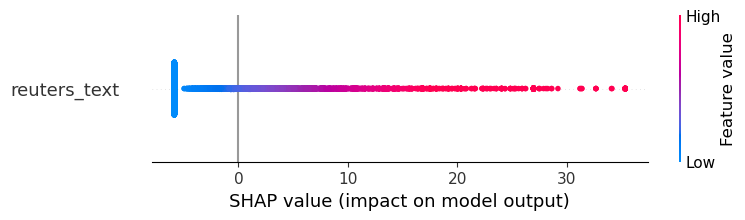

In [108]:
explainer = shap.Explainer(log_clf, test_features_df[['reuters_text']], 
                           feature_names=['reuters'])
shap_values = explainer(test_features_df[['reuters_text']])
shap.plots.beeswarm(shap_values, max_display=20)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


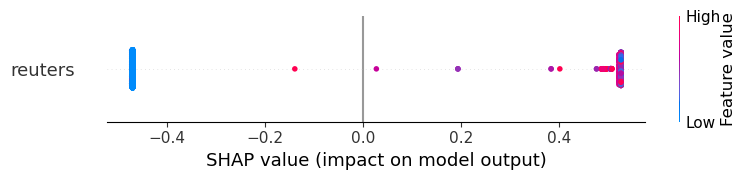

In [109]:
explainer = shap.TreeExplainer(dt_clf)
shap_values = explainer(test_features_df[['reuters_text']])
shap.summary_plot(shap_values[:,:,1], feature_names=['reuters'])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


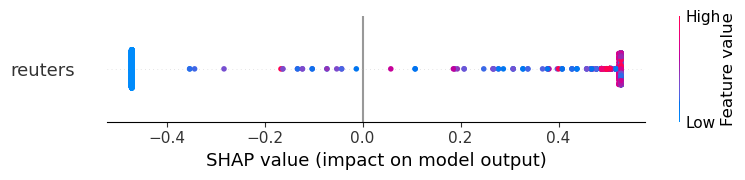

In [110]:
explainer = shap.TreeExplainer(rf_clf)
shap_values = explainer(test_features_df[['reuters_text']])
shap.summary_plot(shap_values[:,:,1], feature_names=['reuters'])

From the SHAP value summary plots it seems that if there is no mention of 'reuters' in the text the models tend to predict fake news (ouputs 0).

In [56]:
test_samples = test_df.sample(5, random_state=0)
test_samples[['title','text','real_news']]

,title,text,real_news
39218,YIKES! ACADEMY AWARD WINNING Actor Starring In...,Batman fans who have been looking forward to t...,0
12243,Japan adopts additional sanctions against Nort...,TOKYO (Reuters) - Japan will impose additional...,1
22164,Trump Has Total UNHINGED Scatter-Brained Ment...,Donald Trump is desperate to distract everyone...,0
817,Kentucky man arrested in assault on Senator Ra...,LOUISVILLE/WASHINGTON (Reuters) - A man has be...,1
34648,PA TRUMP RALLY: How Support From The Amish Com...,Maybe it s the commonality they share with Tru...,0


In [ ]:
tokenizer = AutoTokenizer.from_pretrained(
    "distilbert-base-uncased", 
    do_lower_case=True
)

def pred_fcn(x):
    outputs = model(
        tokenizer.batch_encode_plus(
            list(x),
            add_special_tokens=True,
            max_length=256,
            padding='max_length',
            return_attention_mask=True,
            truncation=True,
            pad_to_max_length=True,
            return_tensors='pt',
        )
    )[1].detach().cpu().numpy()
    
    return outputs[:,1]

explainer = shap.Explainer(pred_fcn, tokenizer)
shap_values = explainer(test_samples['text'])

In [52]:
shap.plots.text(shap_values)

So the force plot shows the influence of words to the model output. Red shows positve and blue negative influence. As we see the DistilBERT language model also associates reuters with real news.

## Summary

**To summarize these are the main things learned and achieved in this project:**
- Title word count was quite powerful in differenciating real and fake news. Using a threshold of 75, accuracy of 82,6% was achieved;
- Accuracies achieved using 20 TFIDF features (10 from title and 10 from text itself) on the validation set: logistic regression - 98.4%, decision tree - 99.2%, random forest - 99.5%;
- From the 20 TFIDF features the word 'reuters' feature had the most predictive power and just by using this feature the following accuracies were achieved on the test set: logistic regression - 97%, decision tree - 99.3%, random forest - 99.3%;
- DistilBERT accuracy on the test set - 99,8%;
- Some samples in the test set had irregular TFIDF scores for 'reuters', which produced high prediction error;
- SHAP value summary plots show that 'reuters' TFIDF feature pushes the model output towards 1 (real news) when it is present;

Overall, in terms of accuracy all of these models can be used in production, but the more logical choice would be logistic regression or decision tree models as they are the simplest models and run very fast. Although, there might not be a special pattern for classifying fake and real news, it might only be specific to this dataset which also includes US presidential election, so it might be biased towards that. For a more advanced system some kind of fact checking method should be used. Also, it could be that this dataset is poorly put together, because just by using one word 'reuters' feature you can get almost 100% accuracy. So this kind of system would be easily fooled, by including reputable sources in the text. On the other hand, this shows the importance of knowing the source of the news as news companies would not risk publishing unverified information.

**Accuracy in terms of retaining people on a site**

So if, without having any news filtering, certain people leave the site just because 50% of news is fake on the site, then using any model mentioned above those people would be retained.

**Suggestions for improvement:**
- Experiment with different datasets if possible;
- Test the built model performance in production;